# Cell Counting

Using https://www.researchgate.net/publication/374381260_Automated_Cell_Counting_using_Image_Processing as reference
<hr>
<img src = "process.png">
<hr>

## Aux Functions and Preparations

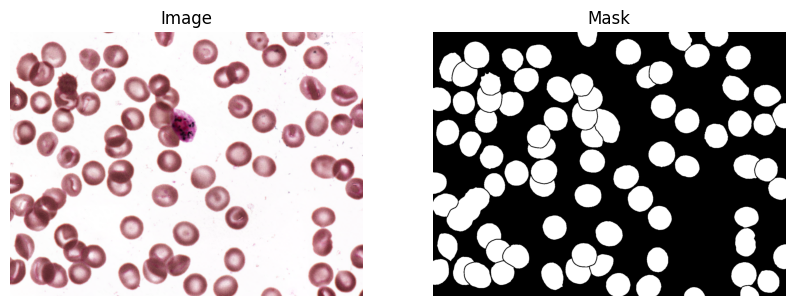

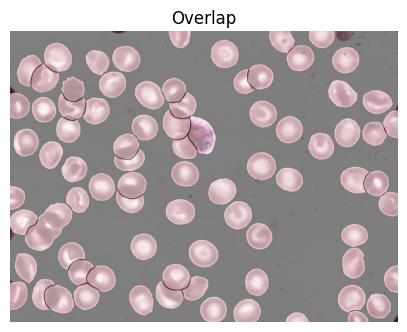

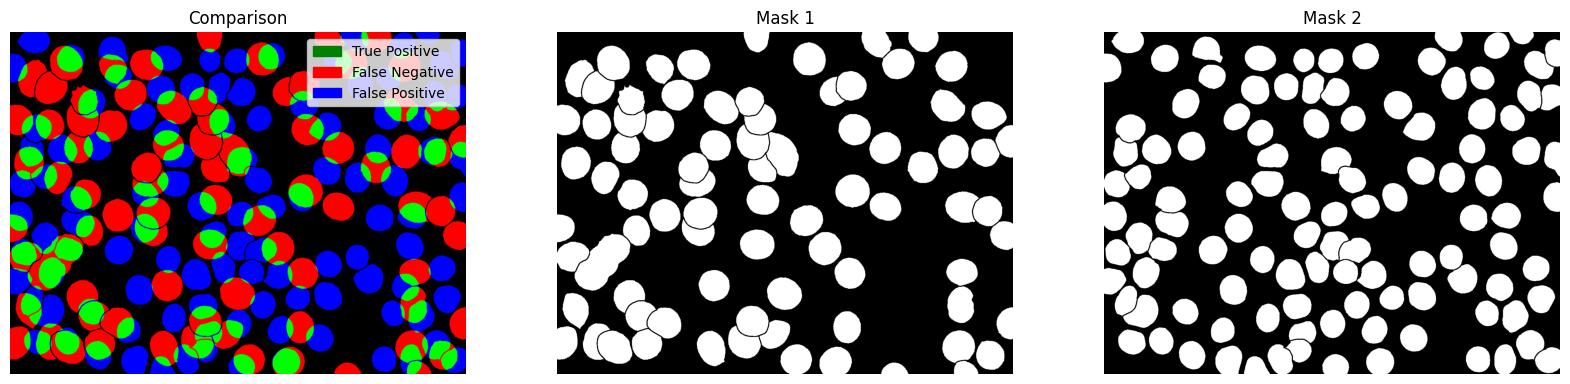

In [1]:

# Imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cv2
import os

# Variables
img_path = os.path.join("BCCD_Dataset", "original") # Doing to prevent any path issues in different OS
mask_path = os.path.join("BCCD_Dataset", "mask")


images = []
masks = []
for filename in os.listdir(img_path): # Images
    file_path = os.path.join(img_path, filename)
    images.append(cv2.imread(file_path))

for filename in os.listdir(mask_path): # Masks
    file_path = os.path.join(mask_path, filename)
    masks.append(cv2.imread(file_path))


# Functions
def load_images(n_of_images:int = 10, img_path:str = img_path, mask_path:str = mask_path):
    images = []
    masks = []
    
    for filename in os.listdir(img_path)[:n_of_images]:
        file_path = os.path.join(img_path, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        images.append(img)

    for filename in os.listdir(mask_path)[:n_of_images]:
        file_path = os.path.join(mask_path, filename)
        mask = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        masks.append(mask)
        
    return images, masks

def show_img_and_mask(img, mask, title_1 = "Image", title_2 = "Mask"):	
    plt.figure(figsize=(10, 10))

    plt.subplot(1,2,1)
    plt.axis("off")
    plt.imshow(img)
    plt.title(title_1)

    plt.subplot(1,2,2)
    plt.axis("off")
    plt.imshow(mask)
    plt.title(title_2)

def compare_two_images(img1, img2, title_1 = "Image 1", title_2 = "Image 2"):
    plt.figure(figsize=(10, 10))
    plt.subplot(1,2,1)
    plt.axis("off")
    plt.imshow(img1)
    plt.title(title_1)

    plt.subplot(1,2,2)
    plt.axis("off")
    plt.imshow(img2)
    plt.title(title_2)

    plt.show()

def show_img_and_mask_overlap(img, mask, title = "Overlap"):
    plt.figure(figsize=(5, 5))

    plt.axis("off")
    plt.imshow(img)
    plt.imshow(mask, alpha=0.5)
    plt.title(title)

def mask_comparison(mask_1, mask_2):
    new_mask = np.zeros(mask_1.shape)

    # False Positive
    blue = (mask_1[:, :, 0] == 255) & (mask_2[:, :, 0] != 255)
    new_mask[blue, 0] = 255

    # True Positive
    green = (mask_1[:, :, 0] == 255) & (mask_2[:, :, 0] == 255)
    new_mask[green, 1] = 255

    # False Negative
    red = (mask_1[:, :, 0] != 255) & (mask_2[:, :, 0] == 255)
    new_mask[red, 2] = 255

    new_mask[:, : , 0] = blue
    new_mask[:,:, 1] = green
    new_mask[:,:, 2] = red

    green_patch = mpatches.Patch(color='green', label='True Positive')
    red_patch = mpatches.Patch(color='red', label='False Negative')
    blue_patch = mpatches.Patch(color='blue', label='False Positive')

    plt.figure(figsize=(20,20))
    plt.subplot(1,3,1)
    plt.imshow(new_mask)
    plt.axis("off")
    plt.title("Comparison")
    plt.legend(handles=[green_patch, red_patch, blue_patch], loc='upper right')

    plt.subplot(1,3,2)
    plt.imshow(mask_1)
    plt.axis("off")
    plt.title("Mask 1")

    plt.subplot(1,3,3)
    plt.imshow(mask_2)
    plt.axis("off")
    plt.title("Mask 2")

    plt.show()

# Min area eh o tamanho minimo de uma celula. Usado para evitar ruido
def count_cells(binary_image, min_area = 100):
    # Converter para grayscale 
    if len(binary_image.shape) == 3:
        binary_image = cv2.cvtColor(binary_image, cv2.COLOR_BGR2GRAY)
    
    # Encontrar contornos
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Criar copia para desenhar contornos
    contour_img = cv2.cvtColor(binary_image.copy(), cv2.COLOR_GRAY2BGR)
    

    cell_count = 0
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > min_area:
            cv2.drawContours(contour_img, [contour], -1, (0, 255, 0), 2)
            cell_count += 1
    
    return contour_img, cell_count

show_img_and_mask(images[0], masks[0])
show_img_and_mask_overlap(images[0], masks[0])
mask_comparison(masks[0], masks[1])

## Image Acquisition

TypeError: Image data of dtype object cannot be converted to float

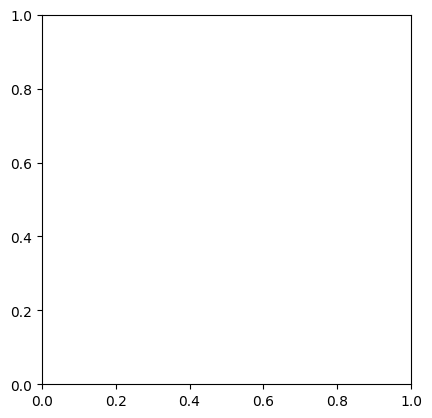

In [2]:
images, masks = load_images(2)
plt.imshow(images[0])
print(f'Primeira e ultima imagem importadas:')
#show_img_and_mask(images[1], masks[1])
#show_img_and_mask(images[-1], masks[-1])

## Image Segmentation

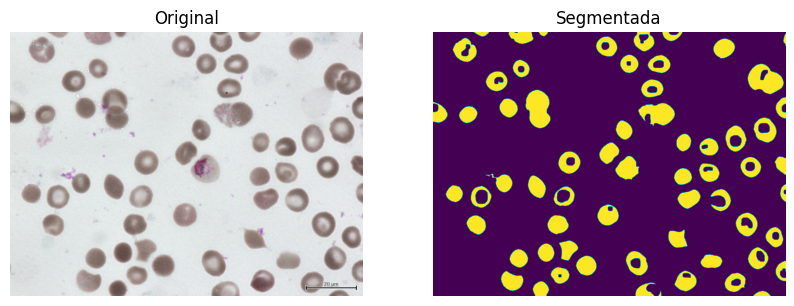

In [97]:
def segment_image(image, kernel_size = (3,3)):
    kernel = np.ones(kernel_size, np.uint8)
    # Converter pra grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # As celulas do dataset sao preto no branco, entao temos que inverter a imagem, se nao as operacoes de erosao e dilatacao ficam "invertidas"
    gray = cv2.invert
    
    # Gaussian blur de lei
    blurred = cv2.GaussianBlur(gray, (7,7), 0)

    # Filtro de mediana para suavizar o ruido
    blurred = cv2.medianBlur(blurred, 9)

    # Otsu
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Operacao de abertura para separar celulas
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

    # Erosao um pouco agressiva para sumir com a escala no canto inferior direito
    erosion = cv2.erode(opening, kernel, iterations=4)

    return erosion


#@TODO: Fazer uma segmentacao watershed, tinha tentado mas ela acabou sumindo com muita celula entao apaguei

compare_two_images(images[0], segment_image(images[0]), "Original", "Segmentada")


## Object Identification

## Objects Counted

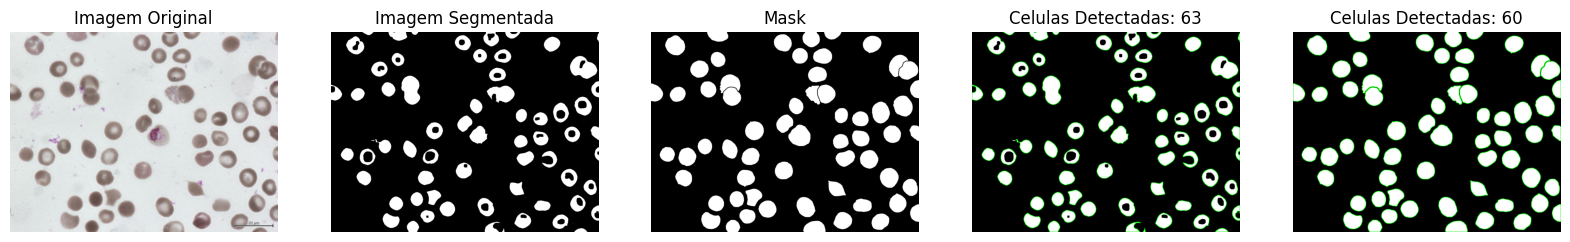

In [102]:
binary_image = segment_image(images[0])
contour_image, count = count_cells(binary_image)


plt.figure(figsize=(20, 5))
plt.subplot(151) 
plt.imshow(images[0])
plt.title('Imagem Original')
plt.axis('off')

plt.subplot(152)  
plt.imshow(binary_image, cmap='gray')
plt.title('Imagem Segmentada')
plt.axis('off')

plt.subplot(153) 
plt.imshow(masks[0])
plt.title('Mask')
plt.axis('off')

plt.subplot(154) 
plt.imshow(contour_image)
plt.title(f'Celulas Detectadas: {count}')
plt.axis('off')

plt.subplot(155)
mask_image, mask_count = count_cells(masks[0])   
plt.imshow(mask_image)
plt.title(f'Celulas Detectadas: {mask_count}')
plt.axis('off')

plt.show()
